<a href="https://colab.research.google.com/github/carlsec/machine_learning/blob/master/Covid_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q kaggle

In [6]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"carlsec","key":"5222e1d65d941c0ceef997f436e4cb5e"}'}

In [7]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle

!chmod 600 /root/.kaggle/kaggle.json

kaggle.json


In [8]:
!kaggle datasets download -d imranzaman5202/covid19-xray-images-dataset

 98% 217M/221M [00:03<00:00, 73.1MB/s]
100% 221M/221M [00:03<00:00, 63.7MB/s]


In [9]:
!unzip /content/covid19-xray-images-dataset.zip

Archive:  /content/covid19-xray-images-dataset.zip
  inflating: Dataset/Covid-19/covid (1).jpeg  
  inflating: Dataset/Covid-19/covid (1).jpg  
  inflating: Dataset/Covid-19/covid (1).png  
  inflating: Dataset/Covid-19/covid (10).jpeg  
  inflating: Dataset/Covid-19/covid (10).jpg  
  inflating: Dataset/Covid-19/covid (10).png  
  inflating: Dataset/Covid-19/covid (100).jpeg  
  inflating: Dataset/Covid-19/covid (100).jpg  
  inflating: Dataset/Covid-19/covid (101).jpeg  
  inflating: Dataset/Covid-19/covid (101).jpg  
  inflating: Dataset/Covid-19/covid (102).jpeg  
  inflating: Dataset/Covid-19/covid (102).jpg  
  inflating: Dataset/Covid-19/covid (103).jpeg  
  inflating: Dataset/Covid-19/covid (103).jpg  
  inflating: Dataset/Covid-19/covid (104).jpeg  
  inflating: Dataset/Covid-19/covid (104).jpg  
  inflating: Dataset/Covid-19/covid (105).jpeg  
  inflating: Dataset/Covid-19/covid (105).jpg  
  inflating: Dataset/Covid-19/covid (106).jpeg  
  inflating: Dataset/Covid-19/covid (

In [10]:
!pip install split-folders

In [11]:
import splitfolders
splitfolders.ratio("/content/Dataset", output="output", seed=1337, ratio=(.8, .1, .1), group_prefix=None)

Copying files: 940 files [00:00, 2189.84 files/s]


In [12]:
import torchvision
import torch.nn as nn
import torch
import torch.nn.functional as F
from torchvision import transforms,models,datasets
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import albumentations as A
from random import shuffle
from torch import optim
import os
import copy
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import cv2, glob, numpy as np, pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from glob import glob
!pip install torch_summary

In [13]:
train_data_dir = '/content/output/train'
val_data_dir =   '/content/output/val'
test_data_dir = '/content/output/test'

# Train


In [147]:
from torch.utils.data import DataLoader, Dataset

class CovidData(Dataset):
  def __init__(self, folder, transform=None, viz=False):
    normal = glob(folder+'/Normal/*')
    covid = glob(folder+'/Covid-19/*')
    self.fpaths = normal + covid
    from random import shuffle, seed; seed(10); shuffle(self.fpaths)
    self.targets = [fpath.split('/')[-1].startswith('Normal') for fpath in self.fpaths] # normal=1 & Covid=0
    self.transform = transform
    self.viz = viz
  def __len__(self): return len(self.fpaths)
  def __getitem__(self, ix):
    f = self.fpaths[ix]
    target = self.targets[ix]
    im = (cv2.imread(f)[:,:,::-1])
    im = cv2.resize(im, (300,300))

    if self.transform is not None:
        im = self.transform(image=im)["image"]

    if self.viz == False:
      return torch.tensor(im/255).permute(2,0,1).to(device).float(), torch.tensor([target]).float().to(device)
    else:
      return torch.tensor(im/255).to(device).float(), torch.tensor([target]).float().to(device)  

In [27]:
data = CovidData(train_data_dir)
im, label = data[300]

In [28]:
len(data)

752

tensor([1.], device='cuda:0')


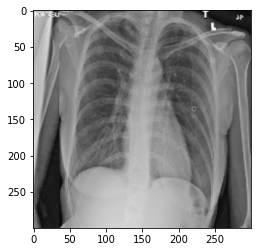

In [29]:
plt.imshow(im.permute(1,2,0).cpu())
print(label) 

In [30]:
train_transform = A.Compose(
    [   A.Resize(300,300),
        #A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        #A.RandomCrop(height=224, width=224),
        #A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        #A.RandomBrightnessContrast(p=0.5),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))])

val_transform = A.Compose(
    [   A.Resize(300,300),
        #A.CenterCrop(height=224, width=224),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))])

In [148]:
def display_image_grid(folder, predicted_labels=(), rows=4, cols=4):
    normal = glob(folder+'/Normal/*')
    covid = glob(folder+'/Covid-19/*')
    image_filepath = normal + covid
    from random import shuffle, seed; seed(10); shuffle(image_filepath)
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 8))
    for i, img in enumerate(image_filepath[:rows*cols]):
        image = cv2.imread(img)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        true_label = os.path.normpath(img).split(os.sep)[-2]
        predicted_label = predicted_labels[i] if predicted_labels else true_label
        color = "green" if true_label == predicted_label else "red"
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_title(predicted_label, color=color)
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()

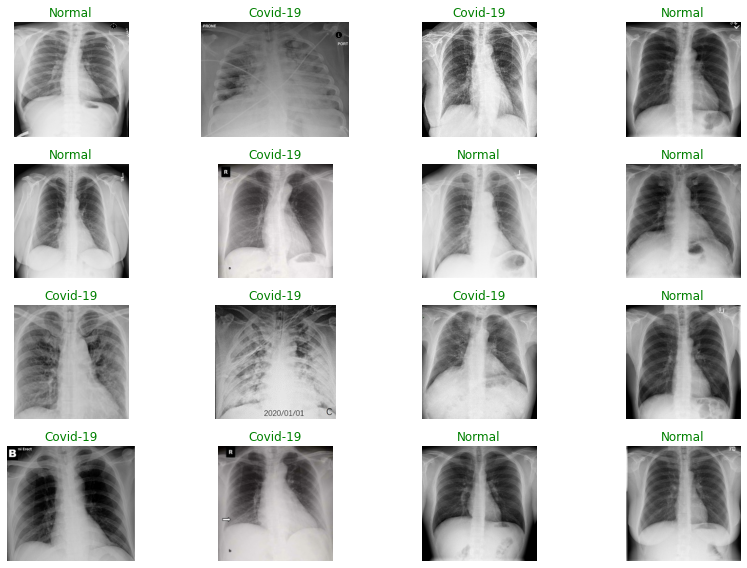

In [149]:
display_image_grid('/content/output/val', rows=4, cols=4)

In [35]:
def get_model():
    model = models.mobilenet_v2(pretrained=True)
    for param in model.parameters():
        param.requires_grad = False
    model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
    model.classifier = nn.Sequential(nn.Flatten(),
    nn.Linear(1280, 1024),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(1024, 1),
    nn.Sigmoid())
    loss_fn = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr= 1e-3)
    return model.to(device), loss_fn, optimizer

In [36]:
!pip install torch_summary
from torchsummary import summary
model, loss_fn, optimizer = get_model()
summary(model, torch.zeros(1,3,300,300));

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 1280, 10, 10]        --
|    └─ConvBNReLU: 2-1                   [-1, 32, 150, 150]        --
|    |    └─Conv2d: 3-1                  [-1, 32, 150, 150]        (864)
|    |    └─BatchNorm2d: 3-2             [-1, 32, 150, 150]        (64)
|    |    └─ReLU6: 3-3                   [-1, 32, 150, 150]        --
|    └─InvertedResidual: 2-2             [-1, 16, 150, 150]        --
|    |    └─Sequential: 3-4              [-1, 16, 150, 150]        (896)
|    └─InvertedResidual: 2-3             [-1, 24, 75, 75]          --
|    |    └─Sequential: 3-5              [-1, 24, 75, 75]          (5,136)
|    └─InvertedResidual: 2-4             [-1, 24, 75, 75]          --
|    |    └─Sequential: 3-6              [-1, 24, 75, 75]          (8,832)
|    └─InvertedResidual: 2-5             [-1, 32, 38, 38]          --
|    |    └─Sequential: 3-7              [-1, 32, 38, 38]          

In [37]:
def train_batch(x, y, model, opt, loss_fn):
    prediction = model(x)
    batch_loss = loss_fn(prediction, y)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item()

@torch.no_grad()
def accuracy(x, y, model):
    prediction = model(x)
    is_correct = (prediction > 0.5) == y
    return is_correct.cpu().numpy().tolist()

@torch.no_grad()
def val_loss(x, y, model):
    prediction = model(x)
    val_loss = loss_fn(prediction, y)
    return val_loss.item()    

In [38]:
def get_data():
  train = CovidData(folder='/content/output/train', transform=train_transform)
  trn_dl = DataLoader(train, batch_size=8, shuffle=True)
  val = CovidData(folder='/content/output/val', transform=val_transform)
  val_dl = DataLoader(val, batch_size=8, shuffle=True)

  return trn_dl, val_dl

In [39]:
def visualize_augmentations(dataset, idx=1, samples=10, cols=5):
    dataset = copy.deepcopy(dataset)
    dataset.transform = A.Compose([t for t in dataset.transform if not isinstance(t, (A.Normalize))])
    rows = samples // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i in range(samples):
        image, _ = dataset[idx]
        ax.ravel()[i].imshow(image.cpu().detach().numpy())
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show() 

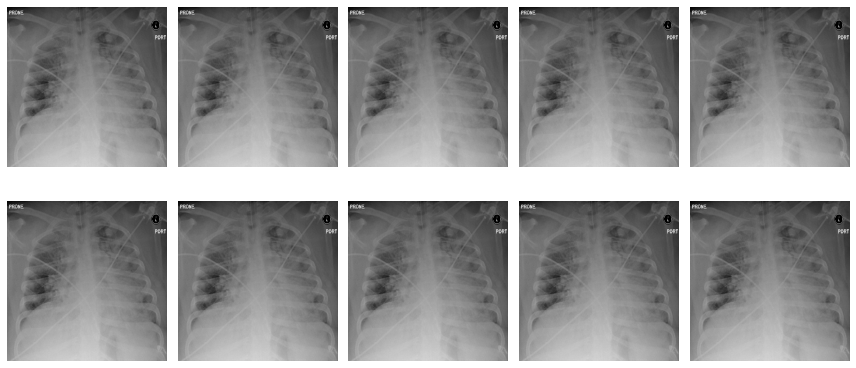

In [40]:
viz = CovidData(folder='/content/output/val', transform=train_transform, viz=True)
visualize_augmentations(viz)

In [42]:
trn_dl, val_dl = get_data()
model, loss_fn, optimizer = get_model()

In [139]:
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []

for epoch in range(20):

    train_epoch_losses, train_epoch_accuracies = [], []
    val_epoch_accuracies = []

    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        train_epoch_losses.append(batch_loss)        
    train_epoch_loss = np.array(train_epoch_losses).mean()

    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)

    for ix, batch in enumerate(iter(val_dl)):
        x, y = batch
        val_is_correct = accuracy(x, y, model)
        val_epoch_accuracies.extend(val_is_correct)
        validation_loss = val_loss(x, y, model)
    val_epoch_accuracy = np.mean(val_epoch_accuracies)

    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_losses.append(validation_loss)
    val_accuracies.append(val_epoch_accuracy)

    print(f"Training Epoch: {epoch}")
    print(f"Train Losses: {train_losses}")
    print(f"Train Accuracy: {train_accuracies}")
    print(f"Val Losses: {val_losses}")
    print(f"Val Accuracy: {val_accuracies}")
    print("-------------------------------------------------------------")

Training Epoch: 0
Train Losses: [0.15918350056249728]
Train Accuracy: [0.9375]
Val Losses: [0.008520844392478466]
Val Accuracy: [0.9354838709677419]
-------------------------------------------------------------
Training Epoch: 1
Train Losses: [0.15918350056249728, 0.10135586064883527]
Train Accuracy: [0.9375, 0.9747340425531915]
Val Losses: [0.008520844392478466, 0.04312928393483162]
Val Accuracy: [0.9354838709677419, 0.9354838709677419]
-------------------------------------------------------------
Training Epoch: 2
Train Losses: [0.15918350056249728, 0.10135586064883527, 0.09226083056753541]
Train Accuracy: [0.9375, 0.9747340425531915, 0.9787234042553191]
Val Losses: [0.008520844392478466, 0.04312928393483162, 0.006959966849535704]
Val Accuracy: [0.9354838709677419, 0.9354838709677419, 0.946236559139785]
-------------------------------------------------------------
Training Epoch: 3
Train Losses: [0.15918350056249728, 0.10135586064883527, 0.09226083056753541, 0.0745409792982676]
Train

In [144]:
@torch.no_grad()
def preds(x, model):
    prediction = model(x)
    is_correct = prediction
    return prediction

In [154]:
test = CovidData(folder='/content/output/test', transform=val_transform)
test_dl = DataLoader(test, batch_size=1, shuffle=False)

predicted_labels = []

with torch.no_grad():
  for batch in test_dl:
      x, y = batch
      predictions = preds(x, model)
      predicted_labels += ["Normal" if cov >= 0.5 else "Covid-19" for cov in predictions]

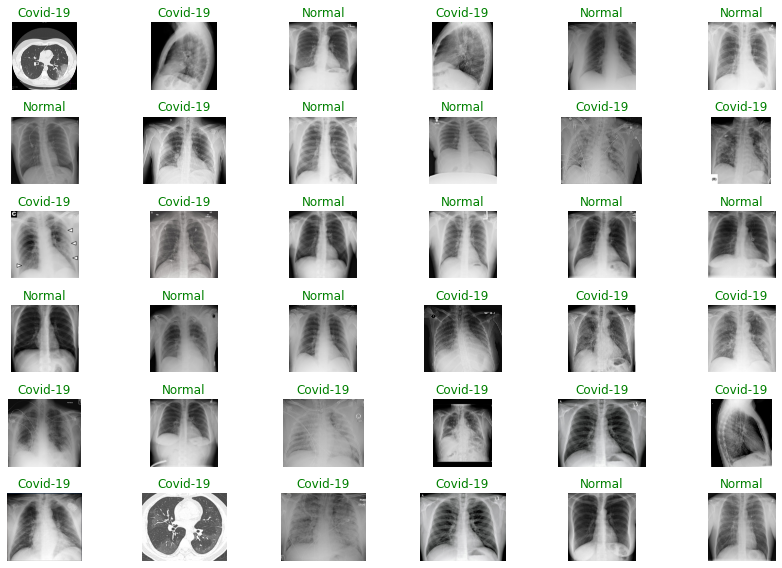

In [159]:
display_image_grid('/content/output/test', predicted_labels, rows=6, cols=6)